In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score


from typing import Dict, Any, Tuple, List, Union, Sequence, Callable


# Attacks

In [20]:

def calculate_metrics_class(y_true:np.array,
                            y_pred: np.array):
    #-> Tuple(float, float, float):
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    pr = average_precision_score(y_true, y_pred)
    return acc, roc, pr

def calc_accuracy(y_true, y_pred, y_pred_adv):
    acc_val = np.mean((y_pred == y_true))
    acc_adv = np.mean((y_pred_adv == y_true))
    return acc_val, acc_adv

def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)


In [21]:
def build_df_aa_metrics(metric_dict:dict, eps:float):
    """ 
    Transform dict with metrics in pd.DataFrame
    
    :param metric_dict: dict key iter number and values list of metrics ACC, ROC AUC, PR AUC
    :param eps: eps param to add in result df
    :return: pd.DataFrame with metrics, number of iterations and eps

    """

    results_df = pd.DataFrame.from_dict(metric_dict, orient="index")
    results_df.set_axis(
        pd.Index(["ACC", "ROC AUC", "PR AUC"], name="metric"), axis=1, inplace=True
    )
    results_df.set_axis(
        pd.Index(results_df.index, name="n steps", ), axis=0, inplace=True,
    )

    results_df = results_df.reset_index()
    results_df['eps'] = eps
    return results_df


def fgsm_attack(loss_val, x, eps):
    
    grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
    x_adv = x.data + eps * torch.sign(grad_)
    return x_adv
    
def fgsm_reg_attack(loss_val, x, eps, alpha):
    
    x_anchor = x[:, 1:-1]
    x_left = x[:, 2:]
    x_right = x[:, :-2]
    x_regular = (x_left + x_right) / 2
    loss_reg = torch.sum((x_anchor - x_regular) ** 2, dim=list(range(1, len(x.shape))))
    
    loss = loss_val - alpha * torch.mean(loss_reg)

    grad_ = torch.autograd.grad(loss, x, retain_graph=True)[0]
    x_adv = x.data + eps * (torch.sign(grad_))

    return x_adv

# def fgsm_reg_attack_v2(loss_val, x, eps, alpha):
    
#     x_anchor = x[:, 1:-1]
#     x_left = x[:, 2:]
#     x_right = x[:, :-2]
#     x_regular = (x_left + x_right) / 2
#     loss_reg = torch.sum((x_anchor - x_regular) ** 2, dim=list(range(1, len(x.shape))))
    
#     #reshaping for correct sum
#     shapes = np.ones(len(x.shape)).astype(int).tolist()
#     shapes[0] = x.shape[0]
#     loss_reg = loss_reg.reshape(tuple(shapes))

#     grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
#     x_adv = x.data + eps * (torch.sign(grad_)) + alpha * loss_reg

#     return x_adv


def attack_one_iter(
        model: nn.Module,  # model for attack
        loader: DataLoader,  # dataloader with data
        criterion: nn.Module,
        attack_fun,
        attack_params,
        device='cpu',
        train_mode=False):  # params_dict with eps and iter number

    """
    Applies 1 iteration of ifgsm adversarial attack to data
    :param model: model to get grad
    :param loader: dataloader with data
    :param criterion: loss function to calculate gradient for attack
    :param eps: the strengh of attack
    :param train_mode: bool to change mode of the model: should be False,
                       but RNN layers can't calculate grad with False value, so need to be set as True
    :return: x_adv_tensor - adversarial data,
            all_y_true - true labels,
            all_preds - predinctions before attack,
            all_preds_adv - predinctions on attacked data
    """
    model.train(train_mode)
    req_grad(model, state=False)  # detach all model's parameters

    all_y_true = []  # logging y_true for rebuilding dataloader and calculation difference with preds
    all_preds = []  # logging predictions original for calculation difference with data
    all_preds_adv = []  # logging predictions for calculation difference with data
    x_adv_tensor = torch.FloatTensor([])  # logging x_adv for rebuilding dataloader

    for x, y_true in loader:
        all_y_true.extend(y_true.detach().data.numpy())

        x.grad = None
        x.requires_grad = True

        # prediction for original input
        x = x.to(device, non_blocking=True)
        y_true = y_true.to(device)
        
        y_pred = model(x)

        # attack for adv input
        loss_val = criterion(y_pred, y_true.reshape(-1, 1))
        
        x_adv = attack_fun(loss_val, x, **attack_params)
#         grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
#         x_adv = x.data + eps * torch.sign(grad_)
        x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)

        # assert (x_adv == x).sum() == 0, "Data doesn't change after attack"
        all_preds.extend(y_pred.cpu().detach().data.numpy())

        # prediction for adv input
        with torch.no_grad():
            y_pred_adv = model(x_adv)
            all_preds_adv.extend(y_pred_adv.cpu().detach().data.numpy())

        # assert (y_pred_adv == y_pred).sum() == 0, "Predicitions doesn't change after attack"

    return x_adv_tensor, all_y_true, all_preds, all_preds_adv


def attack_iterations(model: nn.Module,
                     loader: DataLoader,
                     dataset: Dataset,
                     criterion: nn.Module,
                     attack_fun,
                     attack_params,
                     n_steps: int,
                     metric_fun,
                     device='cpu',
                     batch_size=8,
                     n_objects=100,
                     multiclass=False,
                     train_mode=False,
                     ):

    """
    Run IFGSM attack procedure and logging metrics

    :param model: model to get grad
    :param loader: dataloader with data
    :param criterion: loss function to calculate gradient for attack
    :param eps: the strengh of attack
    :param train_mode: bool to change mode of the model: should be False,
                       but RNN layers can't calculate grad with False value, so need to be set as True
    :return: aa_res_dict  - adversarial data,
            rejection_dict - true labels
    """

    aa_res_dict = dict()

    rejection_dict = dict()
    rejection_dict['diff'] = dict()
    iter_broken_objs = np.array([10 ** 7] * n_objects)

    for iter_ in tqdm(range(n_steps)):

        # attack
        x_adv_tensor, y_true, preds_original, preds_adv = attack_one_iter(model=model, 
                                                                          loader=loader, 
                                                                          criterion=criterion, 
                                                                          attack_fun=attack_fun,
                                                                          attack_params=attack_params, 
                                                                          device=device, 
                                                                          train_mode=train_mode)

        if multiclass:
            preds_flat_round = np.argmax(np.array(preds_original), axis=1).flatten()
            preds_adv_flat_round = np.argmax(np.array(preds_adv), axis=1).flatten()
            y_true_flat = np.array(y_true).flatten()
            shape_diff = (1, 2)

        else:
            preds_flat_round = np.round_(np.array(preds_original)).flatten()
            preds_adv_flat_round = np.round_(np.array(preds_adv)).flatten()
            y_true_flat = np.array(y_true).flatten()
            shape_diff = (1)

        # estimation
        if iter_ == 0:
            iter_broken_objs[preds_flat_round != y_true_flat] = iter_
            aa_res_dict[iter_] = metric_fun(y_true_flat, preds_flat_round)
            preds_iter_1 = np.array(preds_original)

        iter_broken_objs[(preds_adv_flat_round != y_true_flat) & (iter_broken_objs > iter_)] = iter_ + 1

        rejection_dict['diff'][iter_ + 1] = np.sum((preds_iter_1 - np.array(preds_adv)) ** 2, axis=shape_diff)

        rejection_dict['iter_broke'] = iter_broken_objs
        aa_res_dict[iter_ + 1] = metric_fun(y_true_flat, preds_flat_round)

        # rebuilding dataloader for new iteration
        it_dataset = dataset(x_adv_tensor, torch.tensor(y_true))
        loader = DataLoader(it_dataset, batch_size=batch_size)

    return aa_res_dict, rejection_dict


def attack_procedure(model: nn.Module,
                    loader: DataLoader,
                    dataset: Dataset,
                    criterion: nn.Module,
                    attack_fun,
                    attack_params,
                    eps_params, #Tuple[float, float, int],
                    n_steps: int,
                    metric_fun=calculate_metrics_class,
                    device='cpu',
                    batch_size=8,
                    n_objects=100,
                    train_mode=False,
                    ):
    
    aa_res_df = pd.DataFrame()

    rej_curves_dict = dict()  # multilevel dict  eps -> diff and object
    # diff -> #n_iteration -> np.array difference between original prediction without attack and broken predictions
    # object -> np.array n_iter when wrong prediction

    eps_for_check = np.geomspace(*eps_params)

    for eps in tqdm(eps_for_check):
        print(f'*****************  EPS={eps}  ****************')
        attack_params['eps'] = eps

        aa_res_iter_dict, rej_curves_iter_dict = attack_iterations(model, loader, dataset, criterion, attack_fun, attack_params,
                                                                  n_steps, metric_fun, device, batch_size,
                                                                  n_objects, train_mode=train_mode)

        rej_curves_dict[eps] = rej_curves_iter_dict
        aa_res_df = pd.concat([aa_res_df, build_df_aa_metrics(aa_res_iter_dict, eps)])

    return aa_res_df, rej_curves_dict



# Тестирование

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import pickle
import copy

from torch.utils.data import Dataset, DataLoader
from torch import nn

from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from typing import Dict, Any, Tuple, List, Union, Sequence, Callable

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
col = 'FordA'

import sktime
from sktime.datasets import load_from_tsfile

x_train, y_train = load_from_tsfile("data/Ford_A/FordA_TRAIN.ts")
x_test, y_test = load_from_tsfile("data/Ford_A/FordA_TEST.ts")

In [6]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(array([-1,  1]), array([1846, 1755]))
(array([-1,  1]), array([681, 639]))


((3601, 500), (1320, 500), (3601,), (1320,))

In [7]:
def transform_X(X):
    np_data = []
    lens = []
    for i in range(len(X)):
        line = X.iloc[i, 0]
        lens.append(len(line))
        np_data.append(line)
        
    #print(np.mean(lens), np.std(lens))
    return np.array(np_data)

(36010, 50) (13200, 50) (36010, 1) (13200, 1)


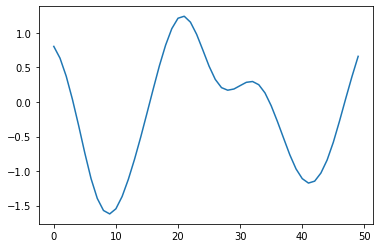

In [8]:
window = 50
len_seq = x_train.shape[1]
n_patches = len_seq//window

X_train = np.vstack([x_train[:, i:i+window] for i in range(n_patches)])
X_test = np.vstack([x_test[:, i:i+window] for i in range(n_patches)])

y_train = np.array([(int(y)+1) // 2 for y in y_train])
y_test = np.array([(int(y)+1) // 2 for y in y_test])

y_train = np.vstack([y_train.reshape(-1, 1) for i in range(n_patches)])
y_test = np.vstack([y_test.reshape(-1, 1) for i in range(n_patches)])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.plot(X_train[1])

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

In [10]:
object_ = X_train_tensor[0:10]
object_anchor = object_[:, 1:-1]
object_left = object_[:, 2:]
object_right = object_[:, :-2]
object_regular = (object_left + object_right) / 2
loss_ = torch.sum((object_anchor - object_regular) ** 2, dim=1)

object_anchor[0], loss_

(tensor([-0.6644, -0.3730,  0.0408,  0.5269,  0.9843,  1.3531,  1.5781,  1.6593,
          1.6408,  1.5523,  1.4380,  1.2794,  1.0691,  0.7445,  0.2776, -0.3007,
         -0.9373, -1.5201, -1.9516, -2.1360, -2.0401, -1.7229, -1.2619, -0.8045,
         -0.4615, -0.2782, -0.2513, -0.3018, -0.3133, -0.2045,  0.0670,  0.4716,
          0.9327,  1.3531,  1.6445,  1.7588,  1.6961,  1.4822,  1.1798,  0.8257,
          0.4495,  0.0725, -0.2970, -0.6460, -0.9742, -1.2508, -1.4094, -1.4279]),
 tensor([0.1762, 0.0533, 0.0424, 0.0656, 0.7286, 0.3582, 0.1882, 0.0556, 0.0688,
         0.1436]))

In [11]:
a = torch.ones((4, 5, 3))
torch.sum(a, dim=list(range(1, len(a.shape)))).shape

torch.Size([4])

## modelling

In [12]:
class MyDataset(Dataset):
    def __init__(self, X, y, window=50):
        super().__init__()
        self.X = X
        self.y = y
        self.window=window
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)

        X = X.reshape([-1, 1])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

    
BS = 64    
train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=BS, shuffle=True)
test_loader = DataLoader(MyDataset(X_test, y_test), batch_size=BS, shuffle=False)

In [13]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))
        output = torch.sigmoid(output)
            
        return output


In [36]:
def train_step(model, loader, criterion, device, optimizer, scheduler=None):
    losses, n_batches = 0, 0
    model.train(True)
    for x, labels in loader:

        optimizer.zero_grad()
        x = x.to(device)
        labels = labels.reshape(-1, 1).to(device)
        
        y_out = model(x)
        loss = criterion(y_out, labels) 
        
        loss.backward()     
        optimizer.step()
        losses += loss
        n_batches += 1

    mean_loss = losses / n_batches

    if scheduler:
        scheduler.step()
    
    return mean_loss

def valid_step(model, loader, criterion, device):
    
    losses, n_batches = 0, 0
    model.eval()    
    for x, labels in loader:
        with torch.no_grad():
            x = x.to(device)
            labels = labels.reshape(-1, 1).to(device)

            y_out = model(x)
            loss = criterion(y_out, labels)
            losses += loss

            n_batches += 1

    mean_loss = losses / n_batches
    return mean_loss


def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1
    
def estimate_epoch(loader, model=None, device='cpu', round_=True, multiclass=False):
    
    y_all_pred = torch.tensor([])
    y_all_true = torch.tensor([])
    
    for X, y_true in loader:
        X = X.to(device)
        y_pred = model(X)
        
        if multiclass:
            y_pred = torch.argmax(y_pred, axis=1)
        else:
            y_pred = torch.round(y_pred)
        
        y_all_true = torch.cat((y_all_true, y_true.cpu().detach()), dim=0)
        y_all_pred = torch.cat((y_all_pred, y_pred.cpu().detach()), dim=0)
        
    y_all_pred = y_all_pred.numpy().reshape([-1, 1])
    y_all_true = y_all_true.numpy().reshape([-1, 1])
    
    acc, pr, rec, f1 = calculate_metrics(y_all_true, y_all_pred)
    
    return acc, pr, rec, f1

def train_procedure(model, train_loader, test_loader, criterion, optimizer, scheduler=None,
                   num_epochs=30, step_print=5):
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_step(model, train_loader, criterion, device, optimizer, scheduler)
        test_loss = valid_step(model, test_loader, criterion, device) 

        acc_train, pr_train, rec_train, f1_train = estimate_epoch(train_loader, model, device=device)
        acc_test, pr_test, rec_test, f1_test = estimate_epoch(test_loader, model, device=device)

        if epoch % step_print == 0:
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
            #plt.hist(y_test_pred)
            #plt.show()
            
    return model


In [37]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor =torch.tensor(X_test, dtype=torch.float32)
X_train_tensor = X_train_tensor.reshape([X_train_tensor.shape[0],X_train_tensor.shape[1], 1])
X_test_tensor = X_test_tensor.reshape([X_test_tensor.shape[0],X_test_tensor.shape[1], 1])

y_train_tensor = torch.tensor(y_train, dtype=torch.int32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32)

In [38]:
def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, pr, rec, f1

def plotting(y_true, y_pred, window=1000):
    plt.figure(figsize=(8, 5))
    plt.plot(y_true[-window:], label = 'True')
    plt.plot(y_pred[-window:], label = 'Pred')
    plt.grid()
    plt.legend()
    plt.show()

## Stop here

In [17]:
model_id = 0
torch.manual_seed(model_id)

In [18]:
device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

num_epochs = 30
print(num_epochs)
LR = 0.001

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.3

model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)

model

30


LSTM_net(
  (rnn): LSTM(1, 50, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [19]:
# model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
#                 num_epochs=15, step_print=5)

#torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{RS}_{col}.pth'

In [20]:
# device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# #device = 'cpu'

# num_epochs = 15
# #print(num_epochs)
# LR = 0.001

# HIDDEN_DIM = 50
# OUTPUT_DIM = 1
# N_LAYERS = 1
# DROPOUT = 0.3

# for model_id in range(5):
#     print(model_id)
#     torch.manual_seed(model_id)

#     model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)

#     criterion = torch.nn.BCELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)
    
#     model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
#                 num_epochs=15, step_print=5)
    
#     torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{model_id}_{col}.pth') 

In [21]:
# for epoch in tqdm(range(num_epochs)):

#     train_loss = train_step(train_loader, model)
#     test_loss = valid_step(test_loader, model) 
    
#     X_test_tensor_loc = X_test_tensor #.reshape([X_test_tensor.shape[0], 1, X_test_tensor.shape[1]])
#     X_train_tensor_loc = X_train_tensor #.reshape([X_train_tensor.shape[0], 1, X_train_tensor.shape[1]])
    
#     y_test_pred = all_predict_training(X_test_tensor_loc.to(device), model).astype('int').reshape(-1)
#     y_train_pred = all_predict_training(X_train_tensor_loc.to(device), model).astype('int').reshape(-1)
       
#     acc_train, pr_train, rec_train, f1_train = calculate_metrics(y_train, y_train_pred)
#     acc_test, pr_test, rec_test, f1_test = calculate_metrics(y_test, y_test_pred)
    
#     if epoch % 5 == 0:
#         #print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; test loss: {test_loss:.3f};')
#         print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; f1_train {f1_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}; f1_test {f1_test:.3f};')
#         plt.hist(y_test_pred)
#         plt.show()
        
#     torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{RS}_{col}.pth')

    

## attacks

In [17]:
from utils.estimation import (plot_aa_metrics, rejection_curves_procedure, 
                              build_basic_dict_curve, build_custom_dict_curve,
                             draw_rejection_curves)
# from utils.attacks import ifgsm_procedure

In [18]:
class LSTM_net(nn.Module):
    def __init__(self, hidden_dim, n_layers, output_dim=1, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(1, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, data):
        
        packed_output, (hidden, cell) = self.rnn(data)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2])
        
        hidden = self.dropout(hidden)
        output = self.relu(self.fc1(hidden))
        output = self.fc2(self.dropout(output))
        output = torch.sigmoid(output)
            
        return output

In [22]:


n_iters = 50
eps_params = (1e-3, 1e0, 5)
criterion = torch.nn.BCELoss()
batch_size = BS
n_objects = y_test.shape[0]

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
train_mode=True

attack_fun = fgsm_reg_attack

#for alpha in tqdm([0.001, 0.01, 0.1, 1, 10, 100]):
for alpha in tqdm([0.01]):
    attack_params = {'alpha':alpha}

    for model_id in range(1):

        path_to_saves = 'checkpoints/Ford_A/'

        model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
        model_path = path_to_saves + f'model_{0}_{col}.pth'
        model.load_state_dict(copy.deepcopy(torch.load(model_path)))

        aa_res_df, rej_curves_dict = attack_procedure(model=model, loader=test_loader, dataset=MyDataset,
                                                     criterion=criterion, attack_fun=attack_fun, attack_params=attack_params,
                                                     eps_params=eps_params, n_steps=n_iters, device=device,
                                                     batch_size=batch_size, n_objects=n_objects, train_mode=train_mode)

        aa_res_df.to_csv(f'results/Ford_A/Gegular/aa_res_Ford_A_{model_id}_alpha={alpha}.csv')
        with open(f'results/Ford_A/Gegular/rej_curves_dict_Ford_A_model_{model_id}_alpha={alpha}.pickle', 'wb') as file:
            pickle.dump(rej_curves_dict, file)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

*****************  EPS=0.001  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.005623413251903491  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.03162277660168379  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=0.1778279410038923  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

*****************  EPS=1.0  ****************


  0%|          | 0/50 [00:00<?, ?it/s]

In [23]:
# aa_res_df= pd.read_csv(f'results/Ford_A/aa_res_Ford_A_{0}.csv', index_col=0)
# aa_res_df

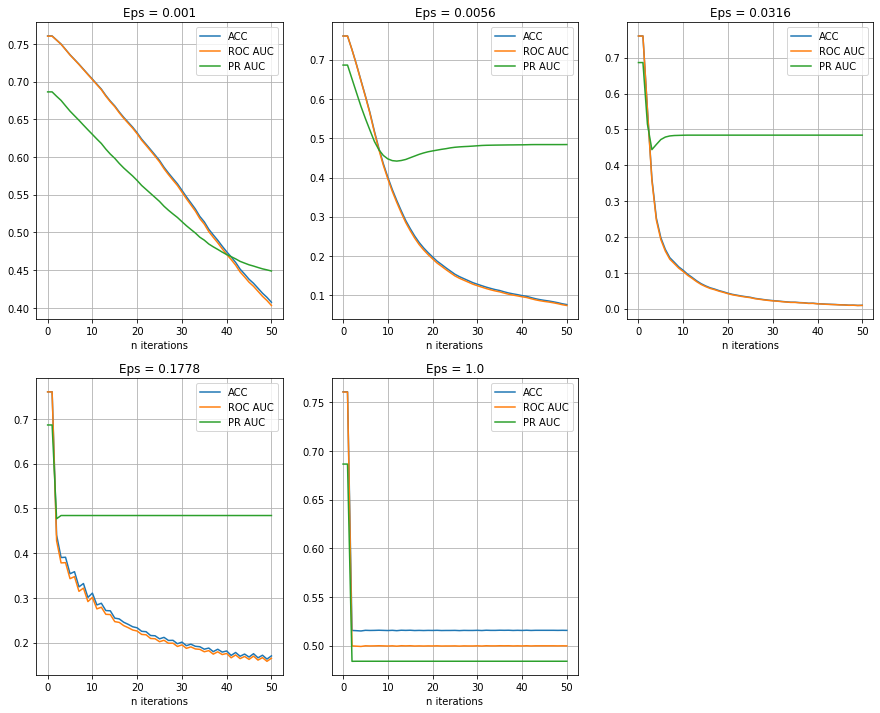

In [26]:
plot_aa_metrics(aa_res_df, method='eps')

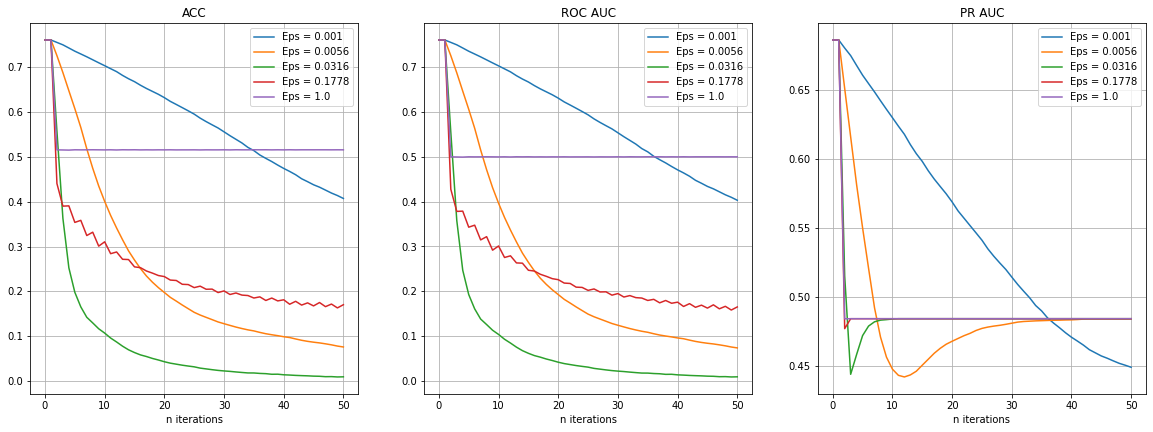

In [27]:
plot_aa_metrics(aa_res_df, method='metric')

In [28]:
def load_LSTM(model, model_path):
    model.load_state_dict(copy.deepcopy(torch.load(model_path)))
    return model


device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.BCELoss()



model_params = {"hidden_dim":50,
                "output_dim":1,
                "n_layers":1,
                "dropout":0.0,
                }
model = LSTM_net(**model_params).to(device)


basic_path = 'checkpoints/Ford_A/model_{}_{}.pth'
load_path = [basic_path.format(i, col) for i in range(5)]


preds, norms = rejection_curves_procedure(model, test_loader,
                               criterion, load_LSTM, load_path, y_test, device,
                               n_models=5)

0th models Accuracy 0.761, ROC-AUC 0.760, PR-AUC 0.686
1th models Accuracy 0.752, ROC-AUC 0.751, PR-AUC 0.678
2th models Accuracy 0.755, ROC-AUC 0.755, PR-AUC 0.682
3th models Accuracy 0.768, ROC-AUC 0.767, PR-AUC 0.696
4th models Accuracy 0.760, ROC-AUC 0.759, PR-AUC 0.688


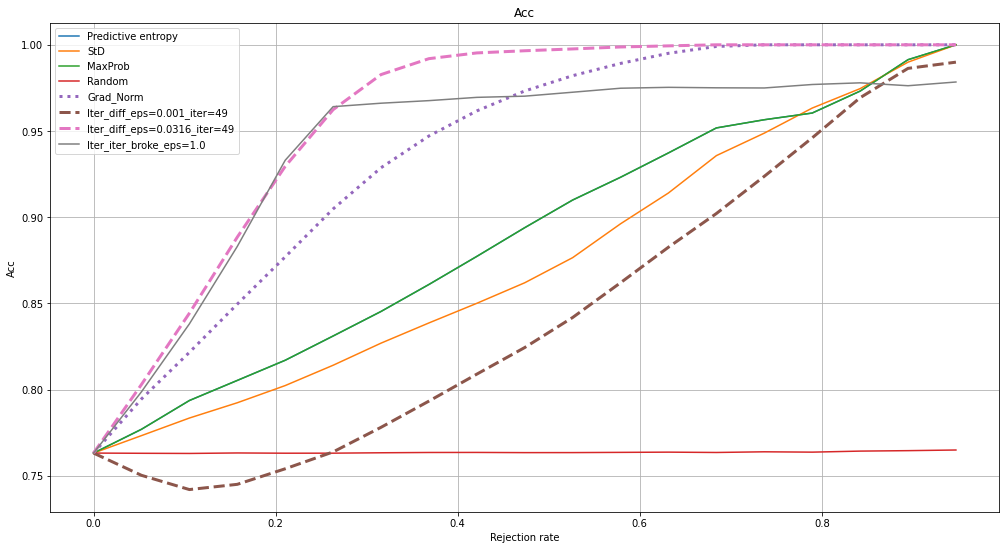

In [29]:
model_id = 0

with open(f'results/Ford_A/rej_curves_dict_Ford_A_model_{model_id}.pickle', 'rb') as file:
    rej_curves_dict = pickle.load(file)


rejection_rates = np.linspace(0, 1.0, 20)
iter_to_break = 49
dict_metrics = {'Acc':accuracy_score,
               #'ROC AUC':roc_auc_score,
               #'PR AUC':average_precision_score
               }

all_eps = list(rej_curves_dict.keys())


dict_curves = build_basic_dict_curve(y_test, preds, norms, rejection_rates, dict_metrics)
dict_curves = build_custom_dict_curve(dict_curves, y_test, preds, norms, rejection_rates, 
                                     dict_metrics, rej_curves_dict, all_eps, iter_to_break)

draw_rejection_curves(dict_curves, rejection_rates)

In [30]:
df_ROC_RC = pd.DataFrame(columns=['metric', 'method', 'value'])

for metric_name, dict_curve_metric in dict_curves.items():
    
    for method_name, list_val in dict_curve_metric.items():
        val = np.array(list_val)
        val_start = val[:-1]
        val_post = val[1:]

        val_mean = np.sum(np.array([val_start, val_post]))/(2*(len(rejection_rates)-1))
        
        dict_res = dict(zip(df_ROC_RC.columns,[metric_name, method_name, val_mean]))
        df_ROC_RC = df_ROC_RC.append(dict_res, ignore_index=True)
        
df_ROC_RC

,metric,method,value
0,Acc,Predictive entropy,0.841414
1,Acc,StD,0.827577
2,Acc,MaxProb,0.841414
3,Acc,Random,0.723388
4,Acc,Grad_Norm,0.889750
5,Acc,Iter_diff_eps=0.001_iter=49,0.797402
6,Acc,Iter_diff_eps=0.0316_iter=49,0.909022
7,Acc,Iter_iter_broke_eps=1.0,0.892901


# Получение адверсальных данных

In [31]:
def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)

def prepare_adv_data(
        model: nn.Module,  # model for attack
        loader: DataLoader,  # dataloader with data
        criterion: nn.Module,
        eps: float,
        device='cpu',
        train_mode=False):  # params_dict with eps and iter number

    model.train(train_mode)
    req_grad(model, state=False)  # detach all model's parameters

    all_y_true = torch.tensor([]) # logging y_true for rebuilding dataloader and calculation difference with preds
    x_adv_tensor = torch.FloatTensor([])  # logging x_adv for rebuilding dataloader

    for x, y_true in loader:
        
        all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
        x.grad = None
        x.requires_grad = True

        # prediction for original input
        x = x.to(device, non_blocking=True)
        y_true = y_true.to(device)

        y_pred = model(x)

        # attack for adv input
        loss_val = criterion(y_pred, y_true.reshape(-1, 1))
        grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
        x_adv = x.data + eps * torch.sign(grad_)
        x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)

    return x_adv_tensor.detach(), all_y_true.detach()

In [32]:
X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([36010, 50, 1]),
 torch.Size([13200, 50, 1]),
 torch.Size([36010, 1]),
 torch.Size([13200, 1]))

In [39]:
eps = 1
criterion = torch.nn.BCELoss()
batch_size = 256
n_objects = y_train.shape[0]
device= torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
train_mode=True

HIDDEN_DIM = 50
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.0

LR = 0.001

num_epochs = 30

for model_id in tqdm(range(1, 5)):
    
    path_to_saves = 'checkpoints/Ford_A/'

    model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
    model_path = path_to_saves + f'model_{model_id}_{col}.pth'
    model.load_state_dict(copy.deepcopy(torch.load(model_path)))
    
    # attack data    
    X_adv, y_adv = prepare_adv_data(model, train_loader, criterion, eps, device, train_mode=train_mode)
            
    #rebuild dataset and dataloader
    new_x_train, new_y_train = torch.concat([X_train_tensor, X_adv], dim=0), torch.concat([y_train_tensor, y_adv], dim=0)
    train_adv_loader = DataLoader(MyDataset(new_x_train, new_y_train), batch_size=BS, shuffle=True)

    
    #train model on attacked data
    torch.manual_seed(model_id)
    model = LSTM_net(HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 12, gamma=0.1)

    model = train_procedure(model, train_loader, test_loader, criterion, optimizer,
                num_epochs=15, step_print=3)
    #save model
    torch.save(model.state_dict(), f'checkpoints/Ford_A/model_{model_id}_{col}_adv.pth') 
    

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1] train loss: 0.693; acc_train 0.513; f1_train 0.089; test loss: 0.692; acc_test 0.509; f1_test 0.085;


KeyboardInterrupt: 